In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
os.listdir("/kaggle/input/dogs-vs-cats")

['test1.zip', 'train.zip', 'sampleSubmission.csv']

In [4]:
train_zip_path = "/kaggle/input/dogs-vs-cats/train.zip"
test_zip_path = "/kaggle/input/dogs-vs-cats/test1.zip"
unzipped_Path = "/kaggle/working/training/"

with zipfile.ZipFile(train_zip_path, 'r') as zip_:
    zip_.extractall(unzipped_Path)
    
with zipfile.ZipFile(test_zip_path, 'r') as zip_:
    zip_.extractall(unzipped_Path)

In [5]:
images = os.listdir('/kaggle/working/training/train')
images_ = os.listdir('/kaggle/working/training/test1')

train_Data = pd.DataFrame({'Image': image, 'Category': 0 if image.split(".")[0] == 'cat' else 1} for image in images)
test_Data = pd.DataFrame({'Image': image} for image in images_)

train_Data

Image  Category
0      dog.10667.jpg         1
1       dog.9434.jpg         1
2       dog.8588.jpg         1
3       dog.4282.jpg         1
4         cat.44.jpg         0
...              ...       ...
24995   dog.1915.jpg         1
24996   dog.4726.jpg         1
24997   cat.4826.jpg         0
24998   dog.4462.jpg         1
24999   cat.3812.jpg         0

[25000 rows x 2 columns]

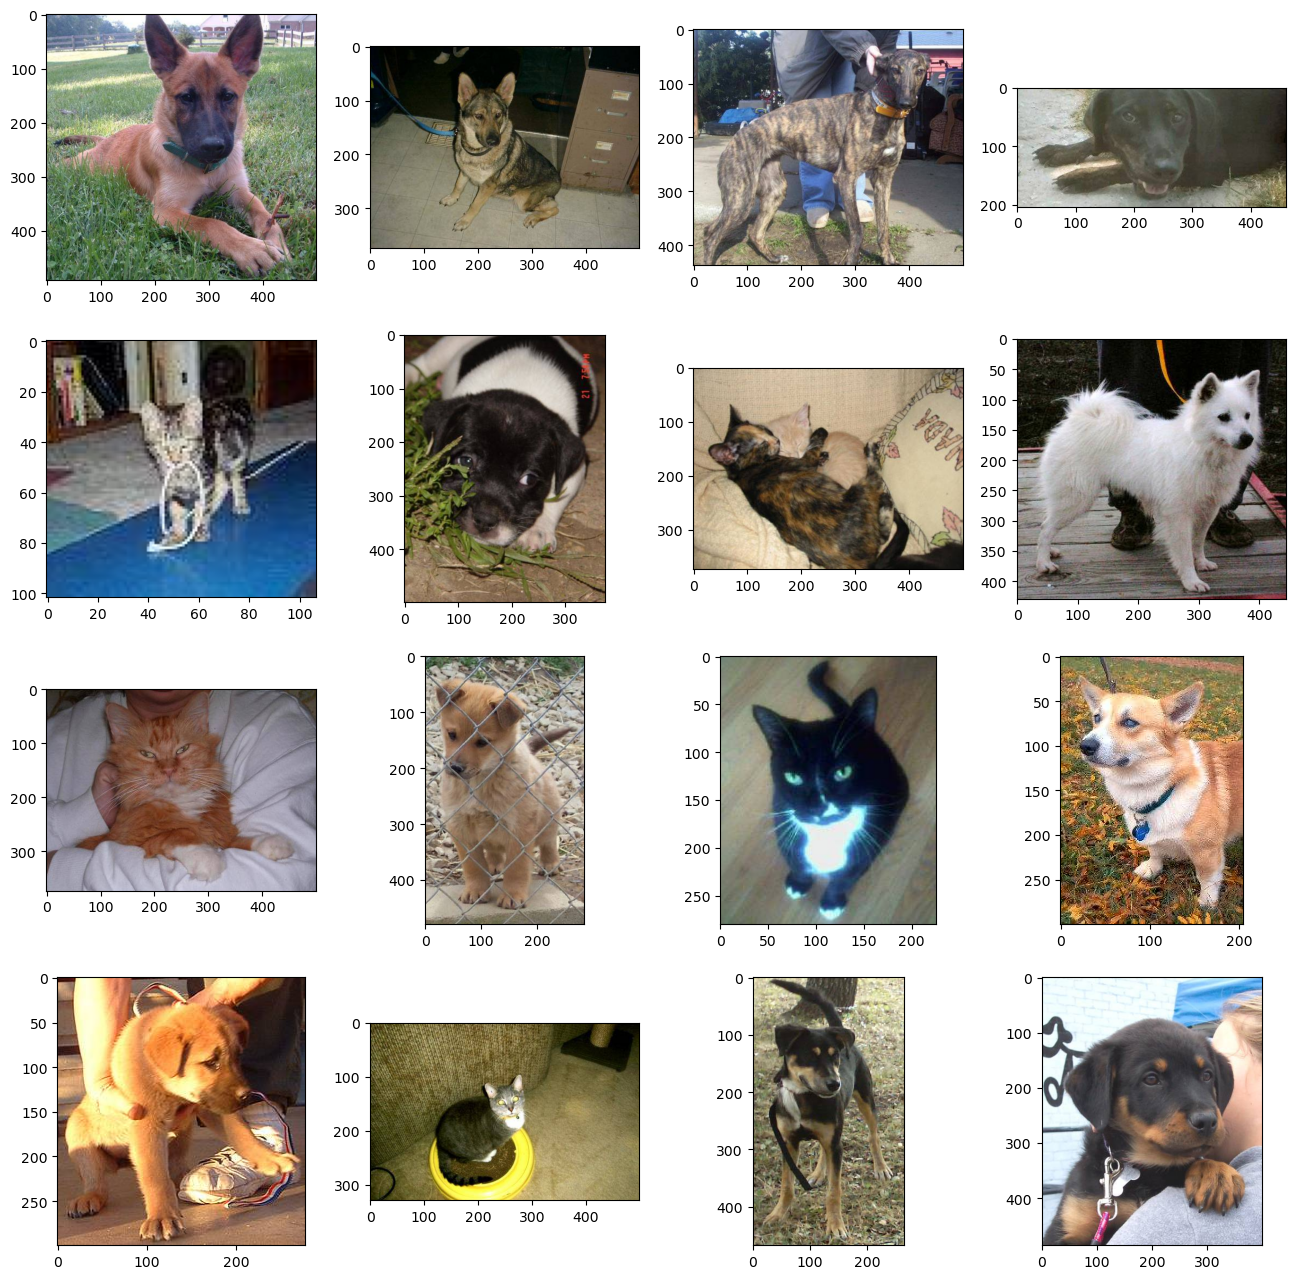

In [6]:
fig = plt.figure(1, figsize=(16, 16))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(Image.open(unzipped_Path + 'train/' + train_Data['Image'][i]))
    
plt.tight_layout
plt.show()

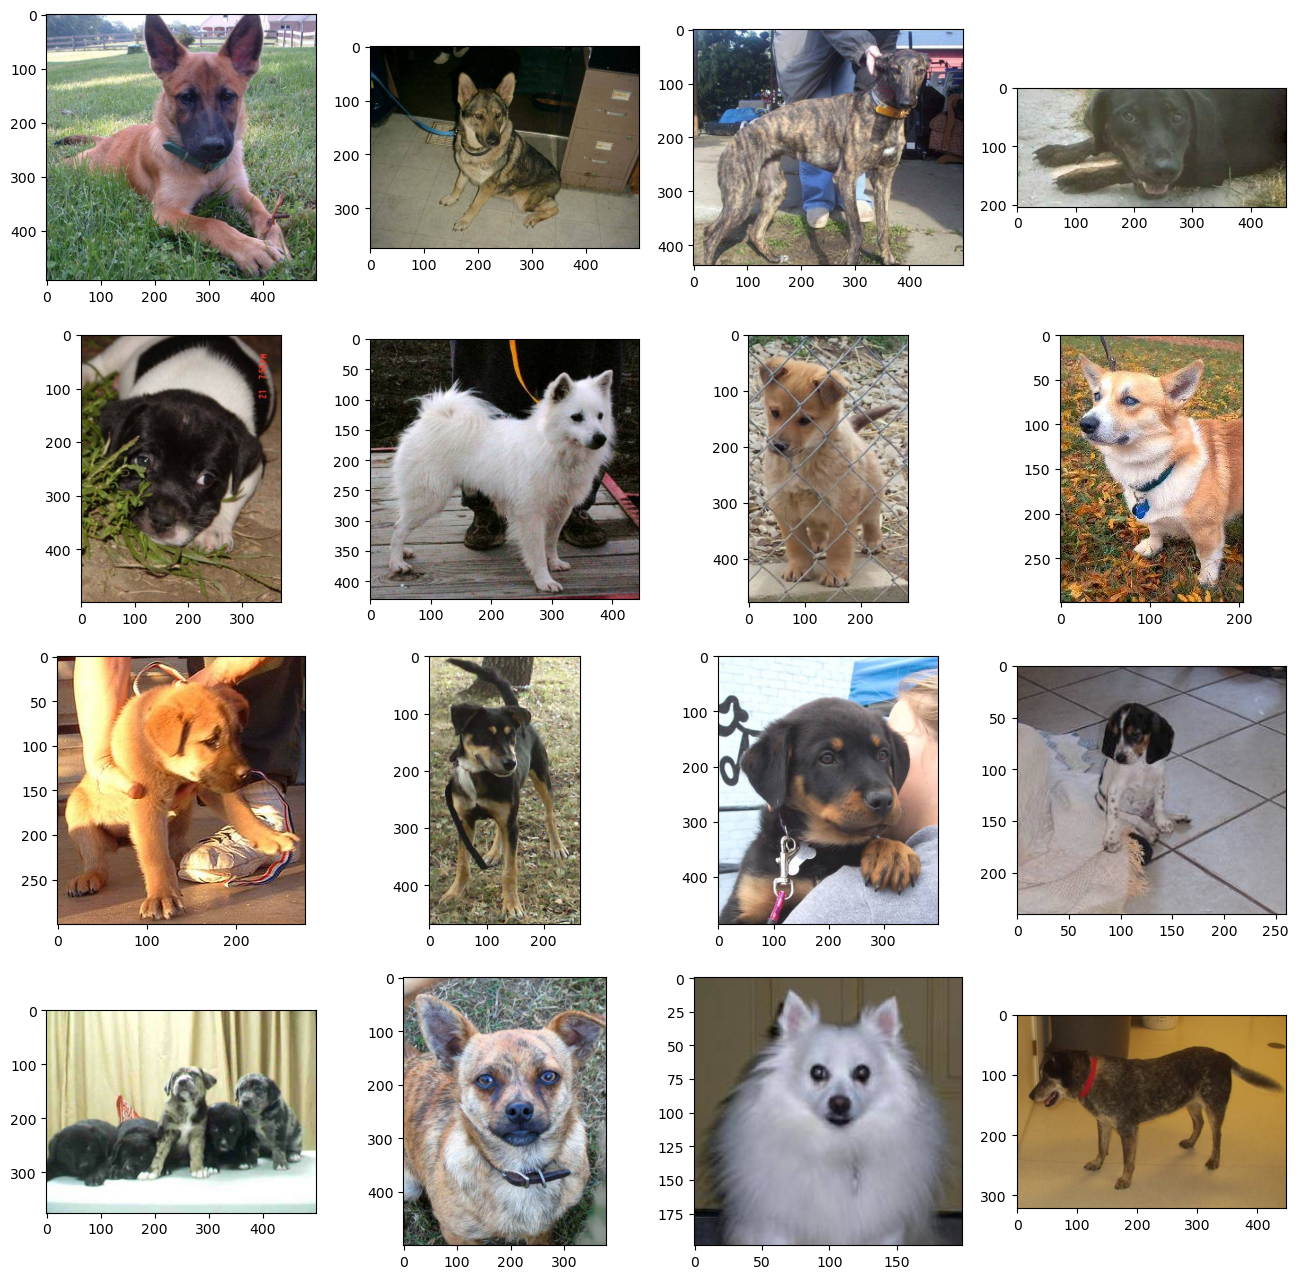

In [7]:
fig = plt.figure(1, figsize=(16, 16))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(Image.open(unzipped_Path + 'train/' + train_Data.query("Category == 1").Image.values[i]))
    
plt.tight_layout
plt.show()

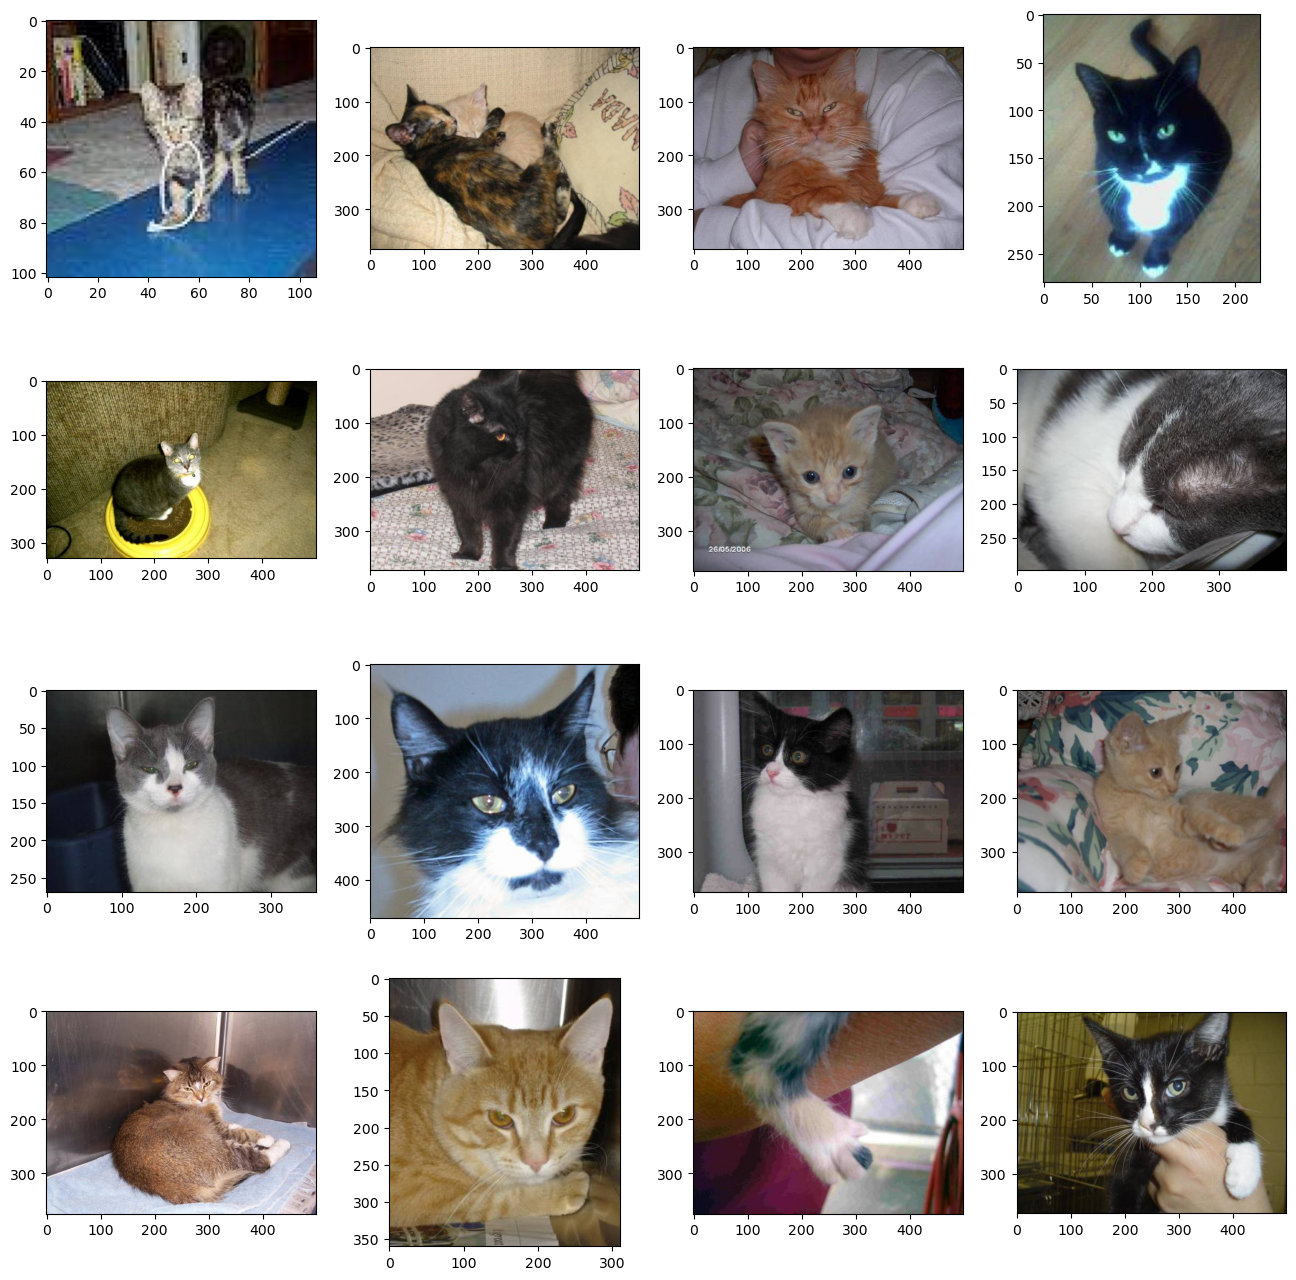

In [8]:
fig = plt.figure(1, figsize=(16, 16))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(Image.open(unzipped_Path + 'train/' + train_Data.query("Category == 0").Image.values[i]))
    
plt.tight_layout
plt.show()

In [9]:
base_model = VGG16(
    weights = "imagenet", 
    input_shape = (224, 224, 3),
    include_top = False
)


for layers in base_model.layers:
    layers.trainable = False


def vgg16_pretrained():
    
    model = Sequential(
        [
            base_model,
            
            Conv2D(128, (3,3), activation = "relu"),
            MaxPool2D(),
            Dropout(0.3),
            
            Flatten(),
            
            Dense(100, activation = "relu"),
            Dropout(0.3),
            
            Dense(64, activation = "relu"),
            Dense(2, activation = "softmax")
        ]
    )
    
    return model

tf.keras.backend.clear_session()

train_data, val_data = train_test_split(train_Data, 
                                        test_size = 0.2, 
                                        stratify = train_Data["Category"], 
                                        random_state = 42)

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [11]:
train_data['Category'] = train_data['Category'].astype(str)
val_data['Category'] = val_data['Category'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = unzipped_Path + "train/",
    x_col = "Image",
    y_col = "Category",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = unzipped_Path + "train/",
    x_col = "Image",
    y_col = "Category",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42,
    shuffle = False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
model = vgg16_pretrained()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                        

In [13]:
history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=val_generator)

Epoch 1/10


2023-07-17 21:07:02.246737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 153s 822ms/step - loss: 0.5745 - accuracy: 0.9517 - val_loss: 0.0902 - val_accuracy: 0.9770
Epoch 2/10
157/157 [==============================] - 126s 799ms/step - loss: 0.1224 - accuracy: 0.9736 - val_loss: 0.0683 - val_accuracy: 0.9788
Epoch 3/10
157/157 [==============================] - 126s 800ms/step - loss: 0.0705 - accuracy: 0.9815 - val_loss: 0.0692 - val_accuracy: 0.9804
Epoch 4/10
157/157 [==============================] - 125s 796ms/step - loss: 0.0506 - accuracy: 0.9865 - val_loss: 0.0624 - val_accuracy: 0.9810
Epoch 5/10
157/157 [==============================] - 125s 792ms/step - loss: 0.0445 - accuracy: 0.9867 - val_loss: 0.0514 - val_accuracy: 0.9810
Epoch 6/10
157/157 [==============================] - 126s 797ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0646 - val_accuracy: 0.9806
Epoch 7/10
157/157 [==============================] - 125s 794ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.0582 - val_accura

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_Data,
    directory = unzipped_Path + "test1/",
    x_col = "Image",
    y_col = None,
    class_mode = None,
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42,
    shuffle = False
)

Found 12500 validated image filenames.


In [15]:
test_preds = model.predict(test_generator)

98/98 [==============================] - 65s 659ms/step


In [16]:
predicted_classes = np.argmax(test_preds, axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

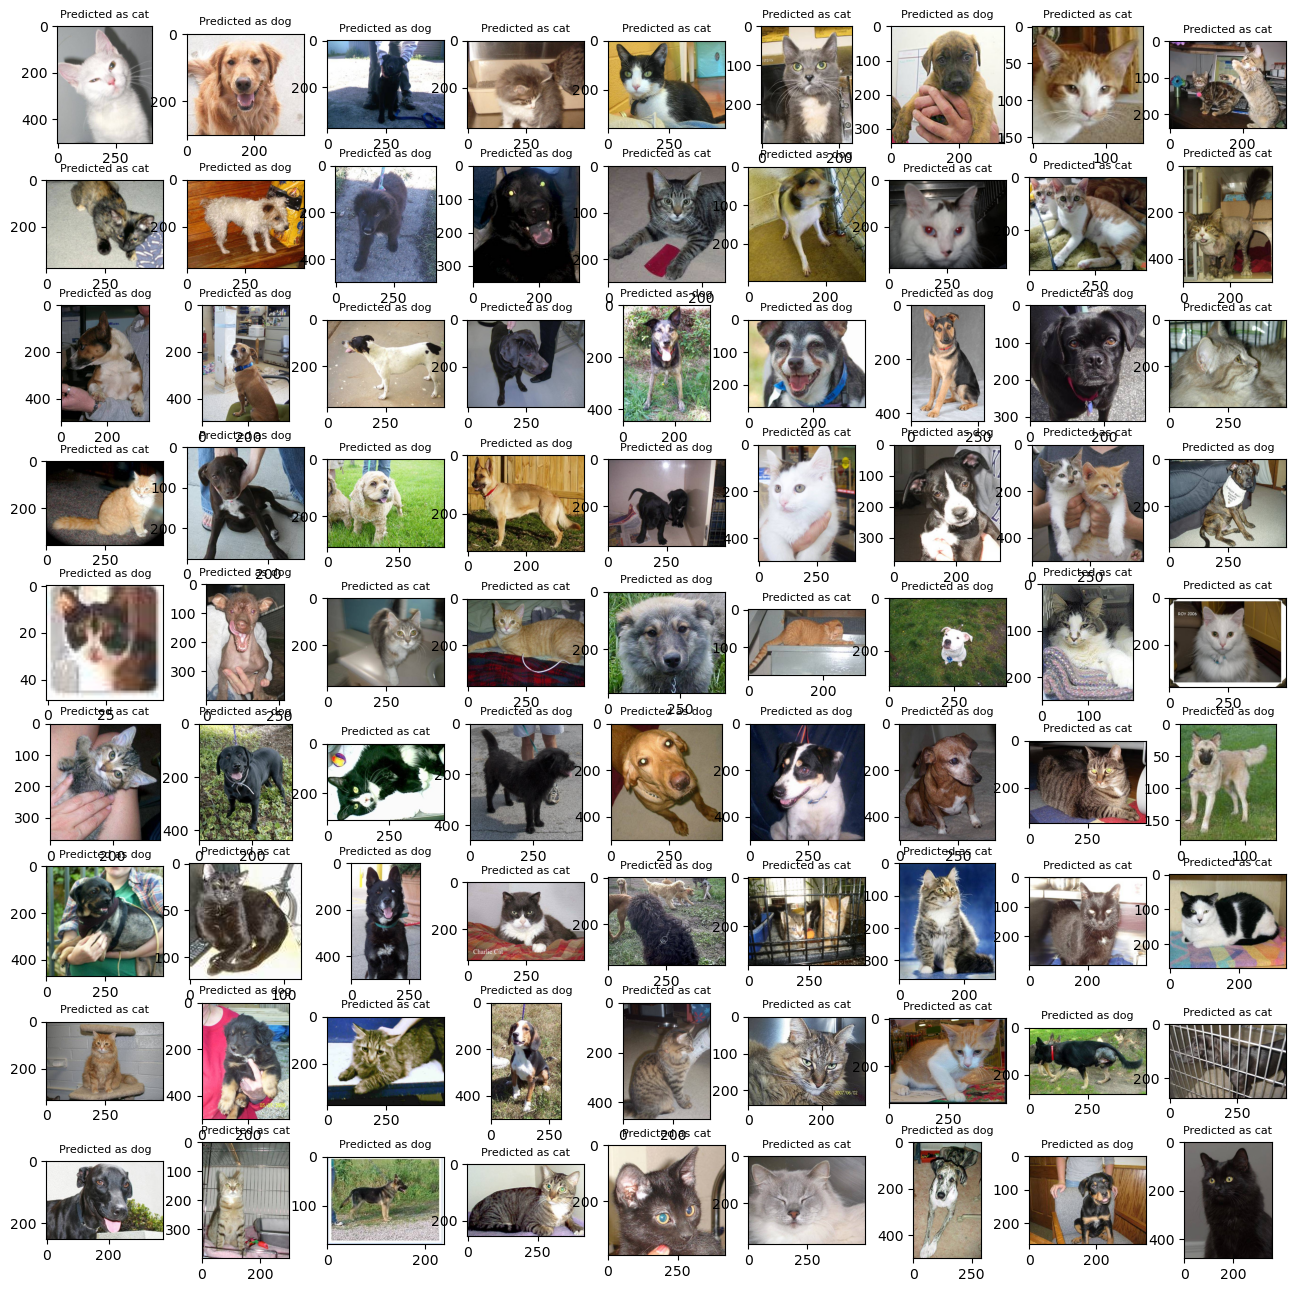

In [17]:
fig = plt.figure(1, figsize=(16, 16))

for i in range(81):
    plt.subplot(9, 9, i+1)
    plt.imshow(Image.open(unzipped_Path + 'test1/' + test_Data['Image'][i]))
    plt.title(f"Predicted as {'dog' if predicted_classes[i] == 1 else 'cat'}", fontsize=8)
    
plt.tight_layout
plt.show